http://www.statsmodels.org/stable/contingency_tables.html

Statsmodels支持各种分析列联表的方法，包括评估独立性，对称性，同质性的方法，以及处理来自分层人群的表集合的方法。

这里描述的方法主要用于双向表。可以使用对数线性模型分析多路表。Statsmodels目前没有statsmodels.genmod.GLM用于对数线性建模的专用API，但Poisson回归可用于此目的。

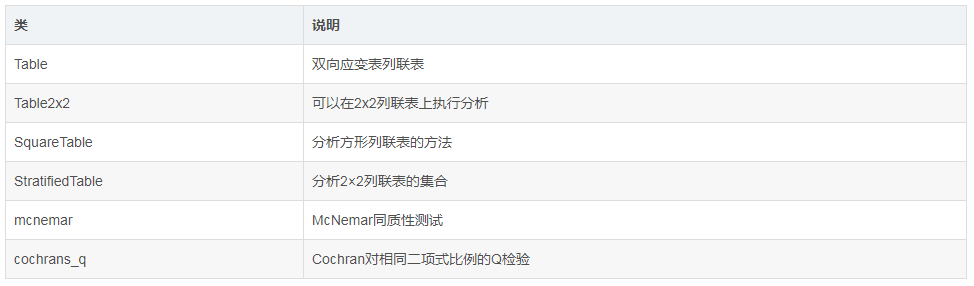

statsmodels.stats.Table是使用列联表的最基本的类。我们可以Table直接从任何包含列联表单元格计数的矩形数组对象创建对象：

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
df = sm.datasets.get_rdataset("Arthritis", "vcd").data
tab = pd.crosstab(df['Treatment'], df['Improved'])
tab = tab.loc[:, ["None", "Some", "Marked"]]
table = sm.stats.Table(tab)

In [17]:
df.head()

,ID,Treatment,Sex,Age,Improved
0,57,Treated,Male,27,Some
1,46,Treated,Male,29,None
2,77,Treated,Male,30,None
3,17,Treated,Male,32,Marked
4,36,Treated,Male,46,Marked


或者，我们可以传递原始数据，让Table类为我们构建单元格数组：

In [10]:
table = sm.stats.Table.from_data(df[['Treatment','Improved']])

# Independence(独立性)

独立性(Independence)是行和列因子独立出现的属性。联合(Association)缺乏独立性。如果联合分布是独立的，则可以将其写为行和列边缘分布的外积
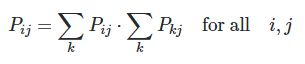

**我们可以为我们观察到的数据获得最佳拟合的独立分布，然后查看识别最强烈违反独立性的特定残差**

In [15]:
table.table_orig

Improved,Marked,None,Some
Treatment,,,
Placebo,7,29,7
Treated,21,13,7


In [14]:
table.fittedvalues

Improved,Marked,None,Some
Treatment,,,
Placebo,14.333333,21.5,7.166667
Treated,13.666667,20.5,6.833333


In [13]:
table.resid_pearson

Improved,Marked,None,Some
Treatment,,,
Placebo,-1.936992,1.617492,-0.062257
Treated,1.983673,-1.656473,0.063758


**如果表的行和列是无序的（即名义变量，nominal factors），那么正式评估独立性的最常用方法是使用Pearson的卡方统计。**

In [26]:
rslt = table.test_nominal_association()
print(rslt.pvalue)

0.0014626434089526352


In [28]:
table.chi2_contribs

Improved,Marked,None,Some
Treatment,,,
Placebo,3.751938,2.616279,0.003876
Treated,3.934959,2.743902,0.004065


**对于有序行和列因子(factors)的表，我们可以通过线性相关检验，以获得更多权重来对抗关于排序的替代假设。线性相关检验的统计量为**
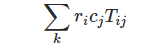

ri,cj是行和列分数。通常将这些分数设置为序列0,1，…
这给出了Cochran-Armitage趋势测试。

In [29]:
rslt = table.test_ordinal_association()
print(rslt.pvalue)

0.023644578093923983


**我们可以通过构建一系列2×2表格并计算它们的比值比(OR)来评估r×x表中的关联。有两种方法可以做到这一点。从相邻行和列类别的本地优势比(local odds ratios)来构建2×2表。**

In [33]:
table.local_oddsratios

Improved,Marked,None,Some
Treatment,,,
Placebo,0.149425,2.230769,NaN
Treated,NaN,NaN,NaN


In [36]:
taloc = sm.stats.Table2x2(np.asarray([[7,29],[21,13]]))
print(taloc.oddsratio)

0.14942528735632185


In [37]:
taloc = sm.stats.Table2x2(np.asarray([[29,7],[13,7]]))
print(taloc.oddsratio)

2.230769230769231


**也可以通过在每个可能的点上对行和列因子进行二分法的累积比值比(cumulative odds ratios)来构建2×2表。**

In [40]:
table.cumulative_oddsratios

Improved,Marked,None,Some
Treatment,,,
Placebo,0.185185,1.058824,NaN
Treated,NaN,NaN,NaN


In [41]:
tab1 = np.asarray([[7, 29 + 7], [21, 13 + 7]])
tacum = sm.stats.Table2x2(tab1)
print(tacum.oddsratio)

0.18518518518518517


In [42]:
tab1 = np.asarray([[7 + 29, 7], [21 + 13, 7]])
tacum = sm.stats.Table2x2(tab1)
print(tacum.oddsratio)

1.0588235294117647


**马赛克图(mosaic plot)是一种非正式评估双向表中依赖性的图形方法。**

In [43]:
from statsmodels.graphics.mosaicplot import mosaic
mosaic(data)

NameError: name 'data' is not defined

# Symmetry and homogeneity(对称性和同质性)

Symmetry(对称性) is the property that


Homogeneity(同质性)是行因子和列因子的边际分布相同的特性
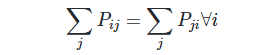

**注意，P (and T)必须是正方形，行和列类别必须相同，并且必须以相同的顺序出现。**

为了说明这点，我们加载一个数据集，创建一个列联表，并计算行和列边距(the row and column margins)。本Table类包含分析方法r×cr×c列联表。下面加载的数据集包含人们左眼和右眼视敏度的评估。我们首先加载数据并创建一个列联表。

In [44]:
df = sm.datasets.get_rdataset("VisualAcuity", "vcd").data
df = df.loc[df.gender == "female", :]
tab = df.set_index(['left', 'right'])
del tab["gender"]
tab = tab.unstack()
tab.columns = tab.columns.get_level_values(1)
print(tab)

timeout: The read operation timed out

从列联表创建一个SquareTable对象

In [46]:
sqtab = sm.stats.SquareTable(tab)
row, col = sqtab.marginal_probabilities
print(row)
print(col)

Improved
Marked     0.025907
None       0.025907
Placebo    0.471503
Some       0.025907
Treated    0.450777
dtype: float64
Improved
Marked     0.316062
None       0.461140
Placebo    0.025907
Some       0.170984
Treated    0.025907
dtype: float64


这种summary方法输出的是对称性和均匀性的检测结果

In [48]:
sqtab.summary()

,Statistic,P-value,DF
Symmetry,78.525,0.000,10
Homogeneity,78.466,0.000,4


如果在名为data的dataframe中有单独的案例记录，我们同样也可以通过使用**SquareTable.from_data类**来完成相同的分析

# A single 2x2 table(单个2x2表)

sm.stats.Table2x2类提供了几种处理单个2x2表的方法。summary方法显示表的行和列之间的若干关联度量。

In [49]:
table = np.asarray([[35,21],[25,58]])
t22 = sm.stats.Table2x2(table)
t22.summary()

,Estimate,SE,LCB,UCB,p-value
Odds ratio,3.867,,1.890,7.912,0.000
Log odds ratio,1.352,0.365,0.636,2.068,0.000
Risk ratio,2.075,,1.411,3.051,0.000
Log risk ratio,0.730,0.197,0.345,1.115,0.000


# Stratified 2x2 tables(分层2x2表)

当我们有一组由同样行和列因子定义的列联表时，就会发生分层。

案例

    我们有一组2x2表，反映了中国几个地区吸烟和肺癌的联合分布。表格可能都具有共同的比值比，即使边际概率在各阶层之间变化也是如此。
    
    “Breslow-Day”程序测试数据是否与常见优势比一致。它在下面显示为常数OR的测试。
    
    Mantel-Haenszel程序测试这个常见优势比是否等于1。它在下面显示为OR = 1的测试。还可以估计共同的几率和风险比并获得它们的置信区间。
    
    summary方法显示所有这些结果。可以从类方法和属性中获得单个结果。

In [55]:
data = sm.datasets.china_smoking.load()
mat = np.asarray(data.data)
tables = [np.reshape(x.tolist()[1:],(2,2)) for x in mat]
st = sm.stats.StratifiedTable(tables)
st.summary()

,Estimate,LCB,UCB
Pooled odds,2.174,1.984,2.383
Pooled log odds,0.777,0.685,0.868
Pooled risk ratio,1.519,,
,,,
,Statistic,P-value,
Test of OR=1,280.138,0.000,
Test constant OR,5.200,0.636,
,,,
Number of tables,8,,
Min n,213,,


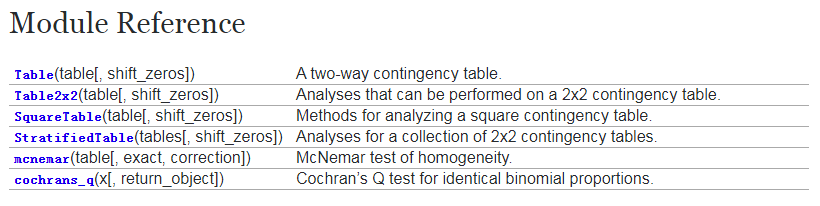